# Как увеличить выручку интернет-магазина? Приоритизация и тестирование гипотез

Есть набор гипотез и надежда, что какие-то из них позволят увеличить выручку интернет-магазина. Нужно выбрать наиболее переспективные и протестировать их. Начнем с загрузки данных и их предобработки.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

hypothesis = pd.read_csv(r'/datasets/hypothesis.csv') # список гипотез и параметры для их ранжирования
orders = pd.read_csv(r'/datasets/orders.csv') # данные о заказах, попавших в тестирование
visitors = pd.read_csv(r'/datasets/visitors.csv') # данные о пользователях, попавших в тестирование

In [2]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [7]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [9]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Пропусков и аномальных значений в данных не видно. В `revenue` должны быть выбросы (среднее и медиана заметно отличаются). Проверим, насколько равномерно распределены данные по двум группам в `orders`.

In [10]:
display(orders.groupby('group')['transactionId'].count())

group
A    557
B    640
Name: transactionId, dtype: int64

В датафрейме с заказами группа B представлена чуть лучше, но не настолько, чтобы это влияло на исход тестирования.

Изменим для удобства названия колонок, столбцы с датами приведем к datetime.

In [11]:
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'effort']
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True) 
orders.date = pd.to_datetime(orders.date)
visitors.date = pd.to_datetime(visitors.date)

Посмотрим, когда проходило A/B тестирование, и задодно убедимся, что в датах нет никаких странностей.

In [12]:
display(visitors.date.min())
display(visitors.date.max())
display(orders.date.min())
display(orders.date.max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

## Приоритизация гипотез


Чтобы определить, какие и в каком порядке обрабатывать гипотезы, применим сначала фреймворк ICE, затем его модификацию RICE. 

ICE позволяет учесть, насколько сильно предложенное изменение должно повлиять на пользователей, сколько усилий/ресурсов это потребует и с какой степенью уверенности можно утверждать, что изменениие приведет именно к таким результатам и издержкам. В RICE дополнительно учтен охват -- какая часть пользователей ощутит на себе это изменение.

In [13]:
hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.effort # расчет ICE
hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.effort # расчет RICE
display(hypothesis.sort_values('ice', ascending=False)) # сортировка в соответствии с ICE
display(hypothesis.sort_values('rice', ascending=False)) # сортировка в соответствии с RICE

,hypothesis,reach,impact,confidence,effort,ice,rice
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


,hypothesis,reach,impact,confidence,effort,ice,rice
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


Видно, что в сортировке по ICE определяющую роль сыграли параметры `impact` и `confidence`, но не `effort`: в число лидеров попали не самые простые в реализации предложения. Хотя и не самые сложные. Если в уравнение добавить `reach`, этот параметр становится одним из определяющих за счет того, что по нему мало середнячков: предложения в списке влияют либо на очень много, либо на очень мало пользователей.

В итоге гипотеза про формы подписки выходит с третьего места на первое, выдавливая на третье место гипотезу про каналы привлечения трафика, несмотря на ее очень высокий `impact`. Но самая разительная перемена происходит с гипотезой про скидки: она занимает первое место по ICE и лишь пятое по RICE, а на второе место перемещается пятая по ICE гипотеза про блоки рекомендаций товаров.

## Анализ результатов A/B теста

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


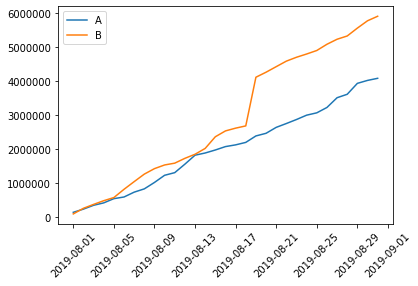

In [14]:
# создадим вспомогательный датафрейм с уникальными сочетаниями дат и групп из orders
dates_and_groups = orders[['date', 'group']].drop_duplicates()

# соберем кумулятивные данные о заказах
orders_cummulative = \
dates_and_groups.apply(lambda x: orders[(orders['date'] <= x['date']) & (orders['group'] == x['group'])]\
.agg({'date': 'max', 'group': 'max', 'transaction_id': 'nunique', 'visitor_id': 'nunique', 'revenue': 'sum'}), axis=1)\
.sort_values(['date', 'group'])

# и кумулятивные данные о посетителях
visitors_cummulative = \
dates_and_groups.apply(lambda x: visitors[(visitors['date'] <= x['date']) & (visitors['group'] == x['group'])]\
.agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1)\
.sort_values(['date', 'group'])

# сведем куммулятивные данные о заказах и посетителях в одну таблицу и дадим столбцам понятные названия
cummulative = orders_cummulative.merge(visitors_cummulative, on=['date', 'group'])
cummulative.rename(columns={'transaction_id': 'orders_cumm',
                            'visitor_id': 'buyers_cumm',
                            'revenue': 'revenue_cumm',
                            'visitors': 'visitors_cumm'}, inplace=True)

# рассчитаем куммулятивные средний чек и конверсию
cummulative['avg_bill_cumm'] = cummulative.revenue_cumm / cummulative.orders_cumm
cummulative['conversion_cumm'] = cummulative.orders_cumm / cummulative.visitors_cumm

# запишем в две отдельные таблицы данные по каждой из групп, чтобы свести их в одну по датам
cummulative_a = cummulative.query('group == "A"')
cummulative_b = cummulative.query('group == "B"')

# создадим сводную таблицу по двум группам
cummulative_merged = cummulative_a.merge(cummulative_b, on='date', suffixes=['_a', '_b'])
cummulative_merged.drop(columns=['group_a', 'group_b'], inplace=True)

# по аналогичному алгоритму подготовим данные по каждой дате (не куммулятивные)
orders_grouped = orders.groupby(['date', 'group'])\
.agg({'transaction_id': 'count', 'visitor_id': 'nunique', 'revenue': 'sum'}) # группировка
orders_grouped.rename(columns={'transaction_id': 'orders', 'visitor_id': 'buyers'}, inplace=True) # переименование колонок
orders_grouped_a = orders_grouped.query('group == "A"').reset_index().drop('group', axis=1) # таблицы по группам
orders_grouped_b = orders_grouped.query('group == "B"').reset_index().drop('group', axis=1) 
visitors_a = visitors.query('group == "A"').drop('group', axis=1) # столбец group лишний, потому что данные о группе
visitors_b = visitors.query('group == "B"').drop('group', axis=1) # есть в суффиксах названий столбцов
orders_visitors_daily = orders_grouped_a.merge(orders_grouped_b, on='date', suffixes=['_a', '_b'])\
.merge(visitors_a, on='date', suffixes=['', '_a'])\
.merge(visitors_b, on='date', suffixes=['_a', '_b']) # сведение не-куммулятивных данных по двум группам

cumm_and_daily_data = cummulative_merged.merge(orders_visitors_daily, on='date') # сведем все данные в одну таблицу

# построим график кумулятивной выручки по группам
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.revenue_cumm_a, label='A')
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.revenue_cumm_b, label='B')
plt.xticks(rotation=45)
plt.legend()

Видно, что в группе B произошел одномоментный скачок, из-за которого выручка резко возросла, но в остальном темпы роста в обеих группах примерно одинаковые. Если это результат рекламной кампании, то можно сказать, что долгосрочного эффекта она не дала, хотя и позволила получить то ли несколько крупных заказов, то ли кратковременное увеличение количества мелких.

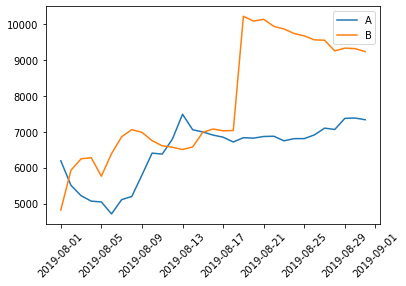

In [15]:
# построим график кумулятивного среднего чека по группам
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.avg_bill_cumm_a, label='A')
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.avg_bill_cumm_b, label='B')
plt.xticks(rotation=45)
plt.legend()

Со средним чеком ситуация более сложная. Если бы не выброс, который отлично виден и на этом графике, можно было бы сказать, что после первоначальных колебаний, при которых графики несколько раз пересекались, в группе А график среднего чека вышел на плато, а в группе B -- перешел к медленному снижению, причем к концу теста группа B проиграла бы группе А. 

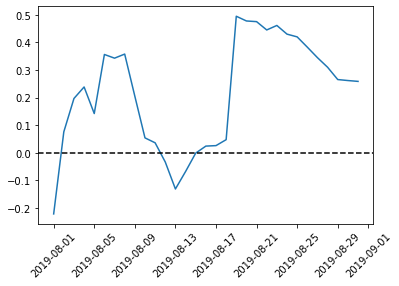

In [16]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A
plt.plot(cumm_and_daily_data.date,
         ((cumm_and_daily_data.avg_bill_cumm_b / cumm_and_daily_data.avg_bill_cumm_a) - 1))
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')

Здесь более наглядно видно, что графики несколько раз пересекались, и опять же заметно, что группа B начала терять преимущество.

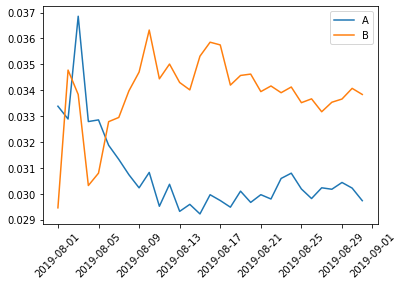

In [17]:
# построим график кумулятивной конверсии по группам
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.conversion_cumm_a, label='A')
plt.plot(cumm_and_daily_data.date, cumm_and_daily_data.conversion_cumm_b, label='B')
plt.xticks(rotation=45)
plt.legend()

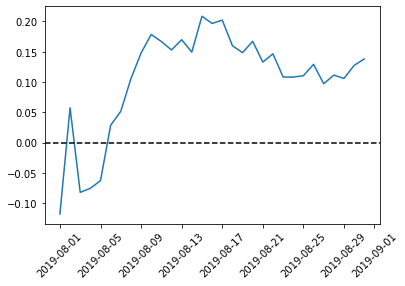

In [18]:
# построим график относительного изменения кумулятивной конверсии группы B к группе A
plt.plot(cumm_and_daily_data.date,
         ((cumm_and_daily_data.conversion_cumm_b / cumm_and_daily_data.conversion_cumm_a) - 1))
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')

На этих двух графиках хорошо виден период первичной неопределенности, а затем явное доминирование группы B по конверсии.

Теперь нужно оценить, насколько зашумлены данные, и исключить влияние выбросов на результат исследования.

array([2., 4.])

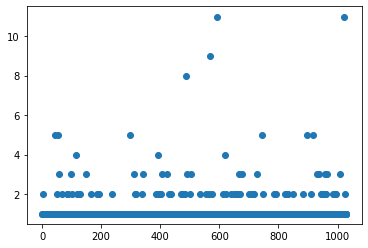

In [19]:
# построим точечный график количества заказов по пользователям
orders_per_user = orders.groupby('visitor_id')['transaction_id'].count()
x_values = pd.Series(range(0, len(orders['visitor_id'].unique())))
plt.scatter(x_values, orders_per_user)

# посчитаем 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(orders_per_user, [95, 99])

95% пользователей совершили не более 2 заказов, 99% -- не более 4. Будем считать пользователей, сделавших более 2 заказов, аномальными и исключим их из расчетов.

array([28000. , 58233.2])

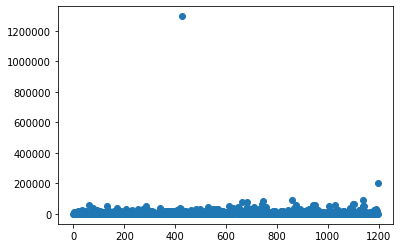

In [20]:
# построим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

# посчитаем 95-й и 99-й перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99])

Причиной резкого скачка на графиках выше стал единственный заказ стоимостью больше миллиона двухсот тысяч. 

In [21]:
display(orders.query('revenue > 1000000'))
display(orders.query('revenue < 1000000').revenue.sum())

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


8698063

19 августа в компании нужно объявить праздничным днем. По стоимости этот заказ, сделанный пользователем из группы B, сопоставим с выручкой за целый месяц.

28000 примем за верхнюю границу стоимости нормального заказа. Все, что дороже, рассматривать не будем. 

Хотя уже ясно, что оценивать результаты теста без очистки данных нельзя, посмотрим, сначала на сырые данные. Во всех тестах порогом статистической значимости будем считать стандартные 5%.

In [22]:
# Посчитаем статистическую значимость различий в конверсии между группами по неочищенным данным
orders_by_users = orders.groupby(['group', 'visitor_id'])['transaction_id'].count().reset_index()
orders_by_users.columns = ['group', 'user', 'num_orders']

orders_by_users_a = orders_by_users.query('group == "A"')
orders_by_users_b = orders_by_users.query('group == "B"')

# массив с нулями по числу пользователей, заходивших на сайт магазина, но не сделавших ни одного заказа 
zero_orders = pd.Series(0, range(cumm_and_daily_data.visitors_a.sum() - len(orders_by_users_a.num_orders)))

sample_a = pd.concat([orders_by_users_a.num_orders, zero_orders], axis=0)
sample_b = pd.concat([orders_by_users_b.num_orders, zero_orders], axis=0)

print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_a, sample_b)[1]))
print('Разница между группами: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.007
Разница между группами: 0.144


На неочищенных данных разница в конверсии между группами составила 14,4% в пользу группы B и оказалась статистически значима.

In [23]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами по неочищенным данным
print('P-value: {0:.3f}'.format(
    st.mannwhitneyu(cumm_and_daily_data.revenue_a, cumm_and_daily_data.revenue_b)[1]))
print('Разница между группами: {0:.3f}'.format(
    cumm_and_daily_data.revenue_b.mean() / cumm_and_daily_data.revenue_a.mean() - 1))

P-value: 0.043
Разница между группами: 0.446


Разница в среднем чеке по сырым данным также статистически значима, хоть и не с таким запасом, как в конверсии. Степень различий при этом очень велика: 44,6%.

Посмотрим, как изменятся результаты после фильтрации данных. Как мы помним, нам нужно исключить пользователей, сделавших три и больше заказов или хотя бы один заказ на сумму более 28 тыс. рублей.

In [24]:
abnormal_users = pd.concat([orders_by_users.query('num_orders > 2').user, orders.query('revenue > 28000').visitor_id])\
.drop_duplicates()

print('Аномальных пользователей: {}'.format(abnormal_users.shape[0]))

sample_a_filtered = pd.concat([
    orders_by_users_a[~orders_by_users_a.user.isin(abnormal_users)].num_orders, zero_orders], axis=0)
sample_b_filtered = pd.concat([
    orders_by_users_b[~orders_by_users_b.user.isin(abnormal_users)].num_orders, zero_orders], axis=0)

# Посчитаем статистическую значимость различий в конверсии между группами по очищенным данным
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Разница между группами: {0:.3f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

Аномальных пользователей: 74
P-value: 0.005
Разница между группами: 0.179


После очистки ситуация с разницей конверсий в группах изменилась незначительно: статистическая значимость результата возросла на 0,2%, сама разница -- на 3,5%.

In [25]:
# Посчитаем статистическую значимость различий в среднем чеке заказа между группами по очищенным данным
print('P-value: {0:.3f}'.format(st.mannwhitneyu(
    orders[~(orders.visitor_id.isin(abnormal_users)) & (orders.group == "A")].revenue, 
    orders[~(orders.visitor_id.isin(abnormal_users)) & (orders.group == "B")].revenue)[1]))
print('Разница между группами: {0:.3f}'.format(
    orders[~(orders.visitor_id.isin(abnormal_users)) & (orders.group == "B")].revenue.mean() / 
    orders[~(orders.visitor_id.isin(abnormal_users)) & (orders.group == "A")].revenue.mean() - 1))

P-value: 0.369
Разница между группами: -0.020


Удаление выбросов кардинально изменило картину со средними чеками: группы поменялись местами и B теперь немного проигрывает A, но это не важно, потому что различия между группами утратили статистическую значимость.

## Выводы

Анализ графиков показыает, что показатели стабилизировались, поэтому продолжать тест смысла нет. Группа B выигрывает у группы А в конверсии, а по среднему чеку статистически значимых различий между группами нет.

Крупный заказ, сделанный 19 августа 2019 года, сильно исказил статистику среднего чека, но закономерным образом почти никак не сказался на статистике конверсии. После очистки данных стало ясно, что тестируемые нововведения никак не сказались на среднем чеке, зато позволили заметно повысить конверсию.

В заключение посмотрим на понедельный график выручки.

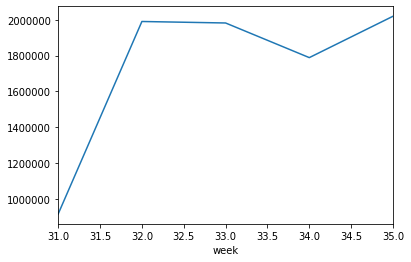

In [26]:
orders['week'] = orders.date.dt.week
orders.query('revenue < 1000000').groupby('week')['revenue'].sum().plot()

Недельная выручка выросла вдвое и стабилизировалась на новом уровне. Теперь мы знаем, что это произошло благодаря росту конверсии.